**Background**  
In the previous notebooks we found that:
- the classifier trained on Hartwig projected on the TSO500 bed file also performed poorly on the training dataset it self (`iii_results_3-1.ipynb`).
- The interquantile range shows a large range of zeroes (`iii_results_3-1.ipynb`).

In the model, we use a signature that is zero as information itself. Probably, the decline in performance is related to false positives. That is to say, the signature attribution in the panel is zero, while on the whole genome it is non-zero.

## Theory
Assume that the size of the exome is 47.9 Mb [1], and note that the panel size of the TSO500 is 1.27 Mb. Assuming a uniform distribution of non-synonymous mutations (while taking into account the panel bias through $r$) we estimate the probability of a detection as $p_{\mathrm{detect}} = 1.27/47.9 \approx 2.65 \%$. So that the probability of a false negative, where no mutation was detected on the panel given $n_{ns}$ non-synonymous mutations:
$$
p({\mathrm{fn}}|n_{\mathrm{ns}}) = (1 -  0.0265)^{n_{\mathrm{ns}}}.
$$
### References
[1]: Alison J Coffey et al. “The GENCODE exome: sequencing the com659 plete human exome”. In: European journal of human genetics 19.7 (2011),
660 pp. 827–831.  

In [18]:
!mkdir -p figs/supplementary_material
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
from numpy import quantile
import pandas as pd
from pandas import read_csv
from sklearn.utils import check_random_state, resample
from statkit.non_parametric import bootstrap_score
from statkit.types import Estimate
from statkit.views import format_p_value

To this end, we compare the actual zeroes as determined by the whole genome sequencing measurements with the same data but then in silico projected on panels of various composition.
Specifically, we consider the panels:
- Tru Sight oncology 500 (TSO500)
- Foundation One CDx (F1 CDx)
- Memorial Sloan Kettering Integrated Mutation Profiling of Actionable Cancer Targets (MSK-IMPACT)
- Pancancer panel of Xu _et al_..

In [2]:
X_hrtw = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_in_silico_tso500 = read_csv('../artifacts/hartwig_in_silico_tso500_signature.tsv', sep='\t', index_col=0)
X_in_silico_f1cdx = read_csv('../artifacts/hartwig_in_silico_foundation_one_cdx_signature.tsv', sep='\t', index_col=0)
X_in_silico_msk468 = read_csv('../artifacts/hartwig_in_silico_msk_468_signature.tsv', sep='\t', index_col=0)
X_in_silico_mask341 = read_csv('../artifacts/hartwig_in_silico_msk_341_signature.tsv', sep='\t', index_col=0)
X_in_silico_mask410 = read_csv('../artifacts/hartwig_in_silico_msk_410_signature.tsv', sep='\t', index_col=0)
X_in_silico_pancan = read_csv('../artifacts/hartwig_in_silico_pan_cancer_signature.tsv', sep='\t', index_col=0)

y_hrtw = X_in_silico_tso500.pop('durable_benefit')
not_na_hrtw = ~y_hrtw.isna()

X_cupp = read_csv('../artifacts/cuppens_signature.tsv', sep='\t', index_col=0)
y_cupp = X_cupp.pop('durable_benefit')

In [3]:
SBS_columns = [c for c in X_cupp.columns if 'SBS' in c]

X_hrtw_counts = X_hrtw[SBS_columns] * 47.9  # Revert count per Mb to count.
non_zero = X_hrtw_counts > 0
X_pos = X_hrtw_counts[non_zero]

Theoretically, the false negative rate can be emperically determined:
$$
p({\mathrm{fn}}) = \langle p({\mathrm{fn}}|n_{\mathrm{ns}}) \rangle_{n_{\mathrm{ns}}}.
$$

In [4]:
def bootstrap(
    metric_fn,
    x,
    n_iterations=1000,
    random_state=None,
    quantile_range: tuple[float, float] = (0.025, 0.975),
):
    random_state = check_random_state(random_state)

    statistics = []
    for _ in range(n_iterations):
        x_sample = resample(x, random_state=random_state)
        estimate = metric_fn(x_sample)
        statistics.append(estimate)

    # Estimate confidence intervals.
    lower = quantile(statistics, quantile_range[0], axis=0)
    upper = quantile(statistics, quantile_range[1], axis=0)
    point_estimate = metric_fn(x)
    return Estimate(point=point_estimate, lower=lower, upper=upper)

In [5]:
length_panels = {
    'TSO500': 1.272_967, 
    'F1 CDx': 1.335_884, 
    'MSK-IMPACT (468)': 1.848_194, 
    'Pan Cancer': 3.999_266, 
}
exome_size = 47.9

def p_false_negative(x, p_hit: float):
    """Probability of a false negative.
    
    Args:
        x: Number of mutations.
        p_hit: Probability of detecting a mutation.
    """
    # Probability of no detection.
    p_miss = 1 - p_hit
    return x.apply(lambda n: p_miss**n).mean()

## Descriptive statistics of false negatives

In [31]:
def coefficient_of_variation(data: pd.DataFrame) -> pd.Series:
    return data.std(axis=0) / data.mean(axis=0)

cv_wgs = coefficient_of_variation(X_hrtw[SBS_columns])
cv_tso500 = coefficient_of_variation(X_in_silico_tso500[SBS_columns])

In [32]:
print('Coefficient of variation, whole genome:', cv_wgs[['SBS4', 'SBS87']])
print('Coefficient of variation, whole genome:', cv_tso500[['SBS4', 'SBS87']])

Coefficient of variation, whole genome: SBS4     1.424256
SBS87    1.034907
dtype: float64
Coefficient of variation, whole genome: SBS4     2.577620
SBS87    2.198666
dtype: float64


In [6]:
def to_contigency_matrix(x_true: pd.Series, x_pred: pd.Series) -> pd.DataFrame:
    """Turn predicted and true values into a contigency matrix."""
    return pd.crosstab(x_true, x_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [7]:
def is_positive(x: float) -> int:
    return int(x > 0)

cm_sbs4 = to_contigency_matrix(X_hrtw.SBS4.apply(is_positive), X_in_silico_tso500.SBS4.apply(is_positive))
cm_sbs87 = to_contigency_matrix(X_hrtw.SBS87.apply(is_positive), X_in_silico_tso500.SBS87.apply(is_positive))

## Theoretical prediction for mutational signatures
For each of the panels, we compute the theoretical predicted signature attribution. We do that for each mutational signatures (except those that are possible sequencing artifacts).

In [11]:
# We will compile our results in this table.
fnr_theory = pd.DataFrame(
    columns=length_panels.keys(),
    index=SBS_columns,
)
# These will be the same as fnr_theory, but with numerical values
# in a format that is convenient for matplotlib.
x_fnr = {
    'TSO500': pd.Series(index=SBS_columns),
    'F1 CDx': pd.Series(index=SBS_columns),
    'MSK-IMPACT (468)': pd.Series(index=SBS_columns),
    'Pan Cancer': pd.Series(index=SBS_columns),
}
xerr_fnr = {
    'TSO500': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'F1 CDx': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'MSK-IMPACT (468)': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'Pan Cancer': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
}

In [12]:
# Theoretical results for all panel-signature pairs.
for name_panel, l_panel in length_panels.items():
    print(f'Theoretically predicted false negative rate {name_panel}:')
    p_hit = l_panel / exome_size
    
    for signature_name in SBS_columns:
        n_pos_signa = X_pos[signature_name].dropna().round()
        if n_pos_signa.sum() == 0:
            # No attributed mutations, so nothing to misattribute.
            fnr_est = Estimate(point=0.0, lower=0.0, upper=0.0)
        else:
            fnr_est = bootstrap(lambda n: p_false_negative(n, p_hit), n_pos_signa, random_state=42)
        print(f"{signature_name}:", fnr_est)
        fnr_theory.loc[signature_name, name_panel] = fnr_est.latex().replace('$', '')
        
        x_fnr[name_panel].loc[signature_name] = fnr_est.point
        xerr_fnr[name_panel].loc[signature_name, 'lower'] = fnr_est.point - fnr_est.lower
        xerr_fnr[name_panel].loc[signature_name, 'upper'] = fnr_est.upper - fnr_est.point

Theoretically predicted false negative rate TSO500:
SBS1: 0.78 (95 % CI: 0.74-0.82)
SBS2: 0.72 (95 % CI: 0.66-0.78)
SBS3: 0.67 (95 % CI: 0.57-0.77)
SBS4: 0.22 (95 % CI: 0.16-0.29)
SBS5: 0.0 (95 % CI: 0.0-0.0)
SBS6: 0.79 (95 % CI: 0.71-0.86)
SBS7a: 0.76 (95 % CI: 0.71-0.81)
SBS7b: 0.78 (95 % CI: 0.73-0.83)
SBS7c: 0.95 (95 % CI: 0.93-0.97)
SBS7d: 0.94 (95 % CI: 0.91-0.96)
SBS8: 0.70 (95 % CI: 0.61-0.79)
SBS9: 0.91 (95 % CI: 0.85-0.97)
SBS10a: 0.91 (95 % CI: 0.88-0.94)
SBS10b: 0.82 (95 % CI: 0.78-0.85)
SBS10c: 0.0 (95 % CI: 0.0-0.0)
SBS10d: 0.96 (95 % CI: 0.92-0.97)
SBS11: 0.95 (95 % CI: 0.90-1.0)
SBS12: 0.95 (95 % CI: 0.92-0.99)
SBS13: 0.65 (95 % CI: 0.59-0.71)
SBS14: 0.76 (95 % CI: 0.71-0.81)
SBS15: 0.76 (95 % CI: 0.70-0.82)
SBS16: 0.89 (95 % CI: 0.86-0.92)
SBS17a: 0.92 (95 % CI: 0.89-0.94)
SBS17b: 0.91 (95 % CI: 0.87-0.94)
SBS18: 0.74 (95 % CI: 0.51-0.97)
SBS19: 0.89 (95 % CI: 0.85-0.92)
SBS20: 0.76 (95 % CI: 0.69-0.81)
SBS21: 0.90 (95 % CI: 0.88-0.93)
SBS22: 0.84 (95 % CI: 0.80-0.87)


## Actual number of false negatives.
Having theoretically predicted the number of false negatives, lets do compare with the actual observations.

In [13]:
def fnr(y_true, y_pred):
    is_fn = (y_pred == 0) & (y_true == 1)
    return is_fn.sum() / (y_true == 1).sum()

In [14]:
def estimate_all_false_negative_rates(X_wgs: pd.DataFrame, X_panel: pd.DataFrame, verbose: bool=True) -> pd.DataFrame:
    """For each mutational signature, estimate the false negative rate.
    
    Args:
        X_wgs_pos: A DataFrame (columns are signatures) with the binarised mutational 
            signatures based on WGS data. A one means that the signature is present, 
            and zero absent.
        X_panel_pos: Like X_wgs_pos, but for the panel data.

    Returns:
        A DataFrame with the point estimate, lower and upper confidence interval.
    """
    # Binarise the mutational signatures.
    X_wgs_pos = (X_wgs[SBS_columns] > 0).astype(int)
    X_panel_pos = (X_panel[SBS_columns] > 0).astype(int)
    
    # Signatures to analyse (excludes artifact signatures).
    fnrs = pd.DataFrame(index=SBS_columns, columns=['point', r'2.5%', r'97.5%', 'latex', 'all negatives'])
    fnrs['all negatives'] = 0
    for s in SBS_columns:
        try:
            fnr_estimate = bootstrap_score(
                X_wgs_pos[s], X_panel_pos[s], metric=fnr, random_state=42
            )
        # When there is nothing to bootstrap, the confidence interval is zero.
        except IndexError:
            assert np.all(X_wgs_pos[s] == 0)
            fnr_estimate = Estimate(point=0.0, lower=0.0, upper=0.0)
            fnrs.loc[s, 'all negatives'] = 1
        fnrs.loc[s, 'point'] = fnr_estimate.point
        fnrs.loc[s, r'2.5%'] = fnr_estimate.lower
        fnrs.loc[s, r'97.5%'] = fnr_estimate.upper
        fnrs.loc[s, 'latex'] = fnr_estimate.latex().replace('$', '')
        if verbose:
            print(f"False negative rate {s}", fnr_estimate)
            print(fnr_estimate.latex())
            print('--')

    return fnrs

In [15]:
# We only evaluate signatures for which signatures are 
# attributed on WGS.
X_wgs_pos = (X_hrtw[SBS_columns] > 0).astype(int)
X_tso500_pos = (X_in_silico_tso500[SBS_columns] > 0).astype(int)
X_f1cdx_pos = (X_in_silico_f1cdx[SBS_columns] > 0).astype(int)
X_msk468_pos = (X_in_silico_msk468[SBS_columns] > 0).astype(int)
X_mask341_pos = (X_in_silico_mask341[SBS_columns] > 0).astype(int)
X_mask410_pos = (X_in_silico_mask410[SBS_columns] > 0).astype(int)
X_pancan_pos = (X_in_silico_pancan[SBS_columns] > 0).astype(int)

In [16]:
# We save the point estimates and error bars of the observed FNR in these variables.
y_fnr = {
    'TSO500': pd.Series(index=SBS_columns),
    'F1 CDx': pd.Series(index=SBS_columns),
    'MSK-IMPACT (468)': pd.Series(index=SBS_columns),
    'Pan Cancer': pd.Series(index=SBS_columns),
}
yerr_fnr = {
    'TSO500': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'F1 CDx': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'MSK-IMPACT (468)': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
    'Pan Cancer': pd.DataFrame(columns=['lower', 'upper'], index=SBS_columns),
}

## TSO500

In [17]:
columns = pd.MultiIndex.from_product((length_panels.keys(), ['theory', 'observed']), names=['panel', 'what'])
fnr_results = pd.DataFrame(
    columns=columns,
    index=SBS_columns,
)
# Assign pre-computed theoretical results.
fnr_results[[(name, 'theory') for name in length_panels.keys()]] = fnr_theory

In [18]:
fnr_tso500 = estimate_all_false_negative_rates(X_hrtw, X_in_silico_tso500)
fnr_results.loc[fnr_tso500.index, ('TSO500', 'observed')] = fnr_tso500['latex']
y_fnr['TSO500'] = fnr_tso500['point']
yerr_fnr['TSO500']['lower'] =  fnr_tso500['point'] - fnr_tso500[r'2.5%']
yerr_fnr['TSO500']['upper'] = fnr_tso500[r'97.5%'] - fnr_tso500['point']

False negative rate SBS1 0.70 (95 % CI: 0.59-0.81)
0.70$^{+0.10}_{-0.11}$
--
False negative rate SBS2 0.44 (95 % CI: 0.32-0.56)
0.44$^{+0.12}_{-0.12}$
--
False negative rate SBS3 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS4 0.67 (95 % CI: 0.56-0.77)
0.67$^{+0.10}_{-0.11}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.81 (95 % CI: 0.62-0.95)
0.81$^{+0.15}_{-0.19}$
--
False negative rate SBS7a 0.75 (95 % CI: 0.63-0.86)
0.75$^{+0.11}_{-0.12}$
--
False negative rate SBS7b 0.87 (95 % CI: 0.77-0.96)
0.87$^{+0.09}_{-0.10}$
--
False negative rate SBS7c 0.93 (95 % CI: 0.75-1.0)
0.93$^{+0.07}_{-0.18}$
--
False negative rate SBS7d 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS8 0.77 (95 % CI: 0.59-0.94)
0.77$^{+0.17}_{-0.19}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.75 (95 % CI: 0.60-0.87)
0.75$^{+0.12}_{-0.15}$
--
False negative rate SB

In [24]:
def plot_theory_experiment(x_fnr, y_fnr, xerr_fnr, yerr_fnr, name):
    plt.plot([0., 1.], [0., 1.], '-')
    is_sbs4 = x_fnr.index == 'SBS4'
    is_sbs87 = x_fnr.index == 'SBS87'
    not_sbs487 = (~is_sbs4) & (~is_sbs87)
    plt.errorbar(
        x_fnr[not_sbs487],
        y_fnr[not_sbs487], 
        xerr=xerr_fnr[not_sbs487].T, 
        yerr=yerr_fnr[not_sbs487].T, 
        fmt='o', 
        label='rest',
        alpha=0.5,
    )
    plt.errorbar(
        x_fnr[is_sbs4], 
        y_fnr[is_sbs4], 
        xerr=xerr_fnr[is_sbs4].T, 
        yerr=yerr_fnr[is_sbs4].T, 
        fmt='o', 
        label='SBS4',
    )
    plt.errorbar(
        x_fnr[is_sbs87], 
        y_fnr[is_sbs87], 
        xerr=xerr_fnr[is_sbs87].T, 
        yerr=yerr_fnr[is_sbs87].T, 
        fmt='o', 
        label='SBS87',
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(f'Theoretically predicted FNR {name}')
    plt.ylabel(f'Observed in silico FNR {name}')
    plt.legend(frameon=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


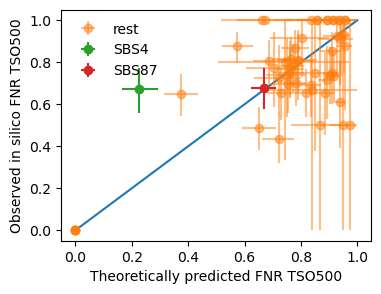

In [25]:
name = 'figs/supplementary_material/fig_s3_theory-experiment_tso500'
f = plt.figure(figsize=(4, 3))
plot_theory_experiment(x_fnr['TSO500'], y_fnr['TSO500'], xerr_fnr['TSO500'], yerr_fnr['TSO500'], name='TSO500')
f.savefig(f'{name}.png')
f.savefig(f'{name}.eps')
f.savefig(f'{name}.pdf')
f.savefig(f'{name}.svg')

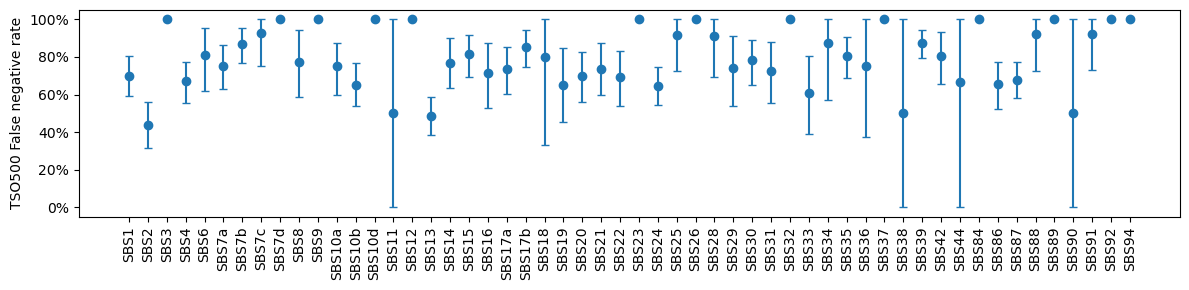

In [141]:
%matplotlib inline
f = plt.figure(figsize=(12, 3))
plt.ylabel(r'TSO500 False negative rate')
fnr_tso500 = fnr_tso500[fnr_tso500['all negatives'] == 0]
yerr = np.array([fnr_tso500['point'] - fnr_tso500[r'2.5%'], fnr_tso500[r'97.5%'] - fnr_tso500['point']])
plt.errorbar(fnr_tso500.index, fnr_tso500['point'] * 100,  yerr=yerr * 100, fmt='o', capsize=3)
# Rotate x-labels bij 90 degrees.
plt.xticks(rotation=90)
# Add percentage to y-labels.
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
# Make the xlabels "SBS4" and "SBS87" bold.
for l in ax.get_xticklabels():
    if l.get_text() in ['SBS4', 'SBS87']:
        l.set_fontweight('bold')
plt.tight_layout()

plt.savefig('figs/supplementary_material/fig_s2_tso500_fnr.pdf', bbox_inches='tight')
plt.savefig('figs/supplementary_material/fig_s2_tso500_fnr.png', bbox_inches='tight')
plt.savefig('figs/supplementary_material/fig_s2_tso500_fnr.svg', bbox_inches='tight')
plt.savefig('figs/supplementary_material/fig_s2_tso500_fnr.eps', bbox_inches='tight')

## Foundation one CDX

In [26]:
fnr_f1cdx = estimate_all_false_negative_rates(X_hrtw, X_in_silico_f1cdx)

False negative rate SBS1 0.73 (95 % CI: 0.63-0.83)
0.73$^{+0.10}_{-0.10}$
--
False negative rate SBS2 0.61 (95 % CI: 0.49-0.72)
0.61$^{+0.11}_{-0.12}$
--
False negative rate SBS3 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS4 0.78 (95 % CI: 0.68-0.87)
0.78$^{+0.09}_{-0.10}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.90 (95 % CI: 0.75-1.0)
0.90$^{+0.10}_{-0.15}$
--
False negative rate SBS7a 0.83 (95 % CI: 0.72-0.92)
0.83$^{+0.09}_{-0.11}$
--
False negative rate SBS7b 0.82 (95 % CI: 0.70-0.93)
0.82$^{+0.11}_{-0.12}$
--
False negative rate SBS7c 0.86 (95 % CI: 0.64-1.0)
0.86$^{+0.14}_{-0.21}$
--
False negative rate SBS7d 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS8 0.95 (95 % CI: 0.85-1.0)
0.95$^{+0.05}_{-0.10}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.88 (95 % CI: 0.76-0.97)
0.88$^{+0.10}_{-0.11}$
--
False negative rate SBS1

In [27]:
fnr_results.loc[fnr_f1cdx.index, ('F1 CDx', 'observed')] = fnr_f1cdx['latex']
y_fnr['F1 CDx'] = fnr_f1cdx['point']
yerr_fnr['F1 CDx']['lower'] =  fnr_f1cdx['point'] - fnr_f1cdx[r'2.5%']
yerr_fnr['F1 CDx']['upper'] = fnr_f1cdx[r'97.5%'] - fnr_f1cdx['point']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


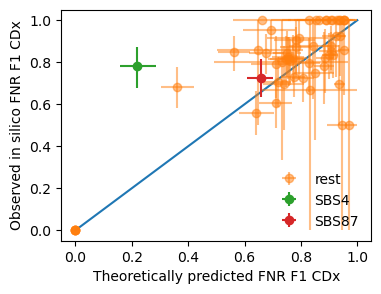

In [28]:
name = 'figs/supplementary_material/fig_s3_theory-experiment_f1cdx'
f = plt.figure(figsize=(4, 3))
plot_theory_experiment(x_fnr['F1 CDx'], y_fnr['F1 CDx'], xerr_fnr['F1 CDx'], yerr_fnr['F1 CDx'], name='F1 CDx')
f.savefig(f'{name}.png')
f.savefig(f'{name}.eps')
f.savefig(f'{name}.pdf')
f.savefig(f'{name}.svg')

## MSK-IMPACT
Here, we compare for the various types of panels:
- 341 genes
- 410 genes
- 468 genes.

In [29]:
fnr_msk468 = estimate_all_false_negative_rates(X_hrtw, X_in_silico_msk468)

False negative rate SBS1 0.72 (95 % CI: 0.62-0.82)
0.72$^{+0.10}_{-0.10}$
--
False negative rate SBS2 0.45 (95 % CI: 0.33-0.56)
0.45$^{+0.11}_{-0.12}$
--
False negative rate SBS3 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS4 0.70 (95 % CI: 0.59-0.80)
0.70$^{+0.10}_{-0.10}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.76 (95 % CI: 0.55-0.92)
0.76$^{+0.15}_{-0.21}$
--
False negative rate SBS7a 0.81 (95 % CI: 0.69-0.90)
0.81$^{+0.10}_{-0.11}$
--
False negative rate SBS7b 0.84 (95 % CI: 0.73-0.93)
0.84$^{+0.09}_{-0.11}$
--
False negative rate SBS7c 0.86 (95 % CI: 0.64-1.0)
0.86$^{+0.14}_{-0.21}$
--
False negative rate SBS7d 0.92 (95 % CI: 0.73-1.0)
0.92$^{+0.08}_{-0.19}$
--
False negative rate SBS8 0.86 (95 % CI: 0.71-1.0)
0.86$^{+0.14}_{-0.16}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.75 (95 % CI: 0.61-0.88)
0.75$^{+0.12}_{-0.14}$
--
False negative ra

In [30]:
fnr_results.loc[fnr_msk468.index, ('MSK-IMPACT (468)', 'observed')] = fnr_msk468['latex']
y_fnr['MSK-IMPACT (468)'] = fnr_msk468['point']
yerr_fnr['MSK-IMPACT (468)']['lower'] =  fnr_msk468['point'] - fnr_msk468[r'2.5%']
yerr_fnr['MSK-IMPACT (468)']['upper'] = fnr_msk468[r'97.5%'] - fnr_msk468['point']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


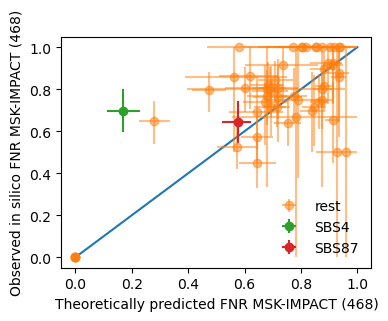

In [31]:
name = 'figs/supplementary_material/fig_s3_theory-experiment_msk468'
f = plt.figure(figsize=(4, 3))
plot_theory_experiment(x_fnr['MSK-IMPACT (468)'], y_fnr['MSK-IMPACT (468)'], xerr_fnr['MSK-IMPACT (468)'], yerr_fnr['MSK-IMPACT (468)'], name='MSK-IMPACT (468)')
f.savefig(f'{name}.png')
f.savefig(f'{name}.eps')
f.savefig(f'{name}.pdf')
f.savefig(f'{name}.svg')

In [32]:
fnr_msk410 = estimate_all_false_negative_rates(X_hrtw, X_in_silico_mask410)

False negative rate SBS1 0.70 (95 % CI: 0.60-0.80)
0.70$^{+0.10}_{-0.10}$
--
False negative rate SBS2 0.49 (95 % CI: 0.37-0.61)
0.49$^{+0.12}_{-0.12}$
--
False negative rate SBS3 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS4 0.73 (95 % CI: 0.62-0.82)
0.73$^{+0.09}_{-0.10}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.81 (95 % CI: 0.61-0.95)
0.81$^{+0.14}_{-0.20}$
--
False negative rate SBS7a 0.77 (95 % CI: 0.66-0.88)
0.77$^{+0.11}_{-0.11}$
--
False negative rate SBS7b 0.89 (95 % CI: 0.79-0.97)
0.89$^{+0.08}_{-0.10}$
--
False negative rate SBS7c 0.93 (95 % CI: 0.75-1.0)
0.93$^{+0.07}_{-0.18}$
--
False negative rate SBS7d 0.92 (95 % CI: 0.73-1.0)
0.92$^{+0.08}_{-0.19}$
--
False negative rate SBS8 0.86 (95 % CI: 0.71-1.0)
0.86$^{+0.14}_{-0.16}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.75 (95 % CI: 0.61-0.88)
0.75$^{+0.12}_{-0.14}$
--
False negative ra

In [33]:
fnr_msk341 = estimate_all_false_negative_rates(X_hrtw, X_in_silico_mask341)

False negative rate SBS1 0.72 (95 % CI: 0.62-0.82)
0.72$^{+0.10}_{-0.10}$
--
False negative rate SBS2 0.52 (95 % CI: 0.39-0.64)
0.52$^{+0.12}_{-0.13}$
--
False negative rate SBS3 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS4 0.73 (95 % CI: 0.62-0.83)
0.73$^{+0.10}_{-0.10}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.86 (95 % CI: 0.69-1.0)
0.86$^{+0.14}_{-0.17}$
--
False negative rate SBS7a 0.79 (95 % CI: 0.68-0.89)
0.79$^{+0.10}_{-0.11}$
--
False negative rate SBS7b 0.89 (95 % CI: 0.79-0.97)
0.89$^{+0.08}_{-0.10}$
--
False negative rate SBS7c 0.93 (95 % CI: 0.75-1.0)
0.93$^{+0.07}_{-0.18}$
--
False negative rate SBS7d 0.92 (95 % CI: 0.73-1.0)
0.92$^{+0.08}_{-0.19}$
--
False negative rate SBS8 0.86 (95 % CI: 0.71-1.0)
0.86$^{+0.14}_{-0.16}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.78 (95 % CI: 0.64-0.89)
0.78$^{+0.11}_{-0.14}$
--
False negative rat

## Pan cancer

In [34]:
fnr_pancan = estimate_all_false_negative_rates(X_hrtw, X_in_silico_pancan)

False negative rate SBS1 0.49 (95 % CI: 0.37-0.61)
0.49$^{+0.12}_{-0.12}$
--
False negative rate SBS2 0.41 (95 % CI: 0.29-0.53)
0.41$^{+0.12}_{-0.12}$
--
False negative rate SBS3 0.94 (95 % CI: 0.79-1.0)
0.94$^{+0.06}_{-0.15}$
--
False negative rate SBS4 0.26 (95 % CI: 0.17-0.36)
0.26$^{+0.10}_{-0.09}$
--
False negative rate SBS5 0.0 (95 % CI: 0.0-0.0)
0.0$^{+0.0}_{0.0}$
--
False negative rate SBS6 0.81 (95 % CI: 0.65-0.95)
0.81$^{+0.14}_{-0.16}$
--
False negative rate SBS7a 0.56 (95 % CI: 0.41-0.70)
0.56$^{+0.14}_{-0.15}$
--
False negative rate SBS7b 0.80 (95 % CI: 0.68-0.91)
0.80$^{+0.11}_{-0.12}$
--
False negative rate SBS7c 0.86 (95 % CI: 0.64-1.0)
0.86$^{+0.14}_{-0.21}$
--
False negative rate SBS7d 0.58 (95 % CI: 0.30-0.88)
0.58$^{+0.29}_{-0.28}$
--
False negative rate SBS8 0.55 (95 % CI: 0.31-0.75)
0.55$^{+0.20}_{-0.23}$
--
False negative rate SBS9 1.0 (95 % CI: 1.0-1.0)
1.0$^{+0.0}_{0.0}$
--
False negative rate SBS10a 0.60 (95 % CI: 0.45-0.75)
0.60$^{+0.15}_{-0.15}$
--
False neg

In [35]:
fnr_results.loc[fnr_pancan.index, ('Pan Cancer', 'observed')] = fnr_pancan['latex']
y_fnr['Pan Cancer'] = fnr_pancan['point']
yerr_fnr['Pan Cancer']['lower'] =  fnr_pancan['point'] - fnr_pancan[r'2.5%']
yerr_fnr['Pan Cancer']['upper'] = fnr_pancan[r'97.5%'] - fnr_pancan['point']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


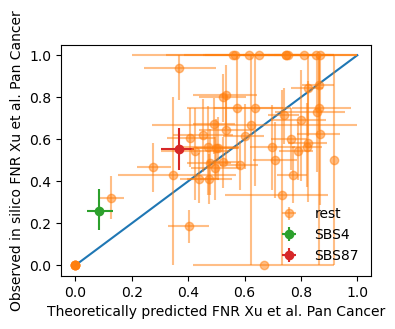

In [37]:
name = 'figs/supplementary_material/fig_s3_theory-experiment_pancan'
f = plt.figure(figsize=(4, 3))
plot_theory_experiment(x_fnr['Pan Cancer'], y_fnr['Pan Cancer'], xerr_fnr['Pan Cancer'], yerr_fnr['Pan Cancer'], name="Xu et al. Pan Cancer")
f.savefig(f'{name}.png')
f.savefig(f'{name}.eps')
f.savefig(f'{name}.pdf')
f.savefig(f'{name}.svg')

In [39]:
fnr_results.to_csv('supplementary_table_1.csv')

## Retrained Donker _et al_. classifier on in silico dataset.
To further show that the performance degradation of the model relates to the panel, we analyse the performance of the model on in silico data. Specifically, we have projected the original (non-synonymous) whole genome sequencing mutations of the Hartwig dataset on to the TSO500 panel (using BED files).

We now test if the classifier still performs poorly (which suggest that the performance drop relates to the panel).

In [ ]:
import pandas as pd
from pandas import DataFrame, read_csv
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from statkit.distributions import ZeroInflatedExponential
from statkit.metrics import binary_classification_report
from statkit.naive_bayes import NaiveBayesClassifier
from statkit.types import Estimate

In [ ]:
# Load the in silico dataset.
X_hrtw_silico = read_csv('../artifacts/hartwig_in_silico_tso500_signature.tsv', sep='\t', index_col=0)
y_hrtw_silico = X_hrtw_silico.pop('durable_benefit')
not_na_hrtw = ~y_hrtw_silico.isna()

SBS_columns = [c for c in X_cupp.columns if 'SBS' in c]
# Normalise by panel size.
X_hrtw_silico[SBS_columns] = X_hrtw_silico[SBS_columns].apply(lambda x: x / 1.27)

In [ ]:
# Prediction threshold based on [1].
# Number of durable benefit:
threshold = 160/365

# Classifier of Donker et al [2].
# Train the classifier (like in [2]) on the Hartwig using these features.
features = ['SBS4', 'SBS87']

# Collect predictions (using leave-one-out cross validation).
clf = NaiveBayesClassifier(ZeroInflatedExponential)
y_hrtw_proba = cross_val_predict(
    clf,
    X_hrtw_silico.loc[not_na_hrtw, features],
    y_hrtw_silico[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.6s finished


In [ ]:
# Quantify performance of predictions using ground truth.
report_hrtw_silico = binary_classification_report(
    y_hrtw_silico[not_na_hrtw], y_hrtw_proba, threshold=threshold
)

metrics_silico = {}
for metric_name, performance in report_hrtw_silico.iterrows():
    estimate = Estimate(**performance)
    metrics_silico[metric_name] = estimate.latex().replace("$", "")
    print(f"{metric_name}: ", estimate)

pd.Series(metrics_silico).to_clipboard()

Accuracy:  0.59 (95 % CI: 0.49-0.69)
Average precision:  0.30 (95 % CI: 0.22-0.41)
$F_1$:  0.14 (95 % CI: 0.0-0.27)
ROC AUC:  0.14 (95 % CI: 5.8e-02-0.25)
Sensitivity:  8.3e-02 (95 % CI: 0.0-0.18)
Specificity:  0.91 (95 % CI: 0.83-0.98)
